In [ ]:
#importing the necessary libraries and packages

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.wrappers.scikit_learn import KerasRegressor
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Dropout
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.random import set_seed
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler
import pickle
import shutil

#setting seed for reproducibility
set_seed(455)
np.random.seed(455)


In [ ]:
#setting warnings to ignore
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#setting rows and columns display limit
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', 10)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199


In [ ]:
#reading the data into a pandas dataframe and viewing it

inquiries = pd.read_csv('inquiries.csv')
product = pd.read_csv('product_types.csv')
inquiries

,id,created_by,style_number,order_number,product_type,bulk_order_quantity,colour_number,materials,currency,additional_information,deleted_at,created_at,updated_at,categories,account_manager_id,company_id,default_image,status,public_status,package,product_name_consumer,product_name_non_consumer,need_trace_approval,trace_rejected_comment,trace_tracking_code,style_name
0,17,117,210528001LAA,1,24,1,1,4,GBP,NaN,NaN,2019-11-03 08:06:29,2022-06-03 16:21:12,6,402.0,12.0,NaN,inactive,1,2,NaN,NaN,NaN,NaN,NaN,NaN
1,18,117,210528002LAA,2,24,1,2,4,GBP,NaN,NaN,2019-11-03 08:07:04,2022-06-03 16:19:31,6,402.0,12.0,NaN,inactive,1,2,NaN,NaN,NaN,NaN,NaN,NaN
2,19,117,210528003LAA,3,24,1,2,4,GBP,NaN,NaN,2019-11-03 08:07:27,2022-06-03 16:22:43,6,402.0,12.0,NaN,inactive,1,2,NaN,NaN,NaN,NaN,NaN,NaN
3,20,117,210528004LAA,4,24,3,3,4,GBP,NaN,NaN,2019-11-03 08:08:05,2022-06-03 16:17:43,6,402.0,12.0,NaN,inactive,1,2,NaN,NaN,NaN,NaN,NaN,NaN
4,21,117,210528005LAA,5,24,1,1,4,GBP,NaN,NaN,2019-11-03 08:08:25,2022-06-03 16:16:46,6,402.0,12.0,NaN,inactive,1,2,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,841,2042,221219001LEC,1,10,1000,4,3,USD,NaN,NaN,2022-12-19 11:48:56,2023-01-23 05:37:17,1,402.0,NaN,NaN,active,1,2,NaN,NaN,NaN,NaN,NaN,Bra
608,842,2043,221230001NNA,1,15,50,3,1,GBP,NaN,NaN,2022-12-30 11:49:38,2022-12-30 11:50:55,1,NaN,NaN,NaN,inactive,0,1,NaN,NaN,NaN,NaN,NaN,Pyjamas
609,843,1916,230123007RED,7,19,600,2,3,USD,This is a duplicate of 220412001RED,NaN,2023-01-23 15:26:05,2023-01-23 15:28:34,2,402.0,NaN,NaN,active,1,2,NaN,NaN,NaN,NaN,NaN,NaN
610,844,1916,230123008RED,8,19,600,2,3,USD,This is a duplicate of 220412001RED,NaN,2023-01-23 15:26:17,2023-01-23 15:29:33,2,402.0,NaN,NaN,active,1,2,NaN,NaN,NaN,NaN,NaN,NaN


# **Exploratory Data Analysis**

In [ ]:
#checking for null values
inquiries.isna().sum()

id                             0
created_by                     0
style_number                   0
order_number                   0
product_type                   0
                            ... 
product_name_non_consumer    599
need_trace_approval          598
trace_rejected_comment       612
trace_tracking_code          607
style_name                   555
Length: 26, dtype: int64

In [ ]:
#checking the datatypes of all columns
inquiries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         612 non-null    int64  
 1   created_by                 612 non-null    int64  
 2   style_number               612 non-null    object 
 3   order_number               612 non-null    int64  
 4   product_type               612 non-null    int64  
 5   bulk_order_quantity        612 non-null    int64  
 6   colour_number              612 non-null    int64  
 7   materials                  612 non-null    int64  
 8   currency                   612 non-null    object 
 9   additional_information     424 non-null    object 
 10  deleted_at                 64 non-null     object 
 11  created_at                 612 non-null    object 
 12  updated_at                 612 non-null    object 
 13  categories                 612 non-null    int64  

In [ ]:
#checking for duplicates
inquiries.duplicated().sum()

0

In [ ]:
#viewing a statistical summary of the data
inquiries.describe()

,id,created_by,order_number,product_type,bulk_order_quantity,colour_number,materials,categories,account_manager_id,company_id,public_status,package,need_trace_approval,trace_rejected_comment
count,612.000000,612.000000,612.000000,612.000000,6.120000e+02,612.000000,612.000000,612.000000,570.000000,232.000000,612.000000,612.000000,14.000000,0.0
mean,503.738562,1279.557190,3.834967,8.746732,5.402064e+03,3.408497,2.460784,3.665033,729.505263,106.650862,0.895425,1.861111,0.642857,NaN
std,229.382192,719.791172,3.932393,7.917097,8.299825e+04,5.559068,1.204233,2.143895,595.738915,60.542308,0.306256,0.680803,0.497245,NaN
min,17.000000,117.000000,1.000000,1.000000,1.000000e+00,-6.000000,1.000000,1.000000,402.000000,12.000000,0.000000,0.000000,0.000000,NaN
25%,345.750000,378.000000,1.000000,3.000000,5.000000e+01,1.000000,1.000000,1.000000,402.000000,58.750000,1.000000,2.000000,0.000000,NaN
50%,539.500000,1704.000000,2.000000,4.000000,1.000000e+02,2.000000,2.000000,4.000000,402.000000,96.000000,1.000000,2.000000,1.000000,NaN
75%,692.250000,1869.000000,5.000000,13.000000,2.000000e+02,3.000000,4.000000,6.000000,402.000000,163.000000,1.000000,2.000000,1.000000,NaN
max,845.000000,2053.000000,21.000000,28.000000,1.451234e+06,50.000000,4.000000,6.000000,2017.000000,226.000000,1.000000,3.000000,1.000000,NaN


In [ ]:
#checking for outliers in numerical variables using zscore

zscore_cols = ['bulk_order_quantity']
z = np.abs(stats.zscore(inquiries[zscore_cols]))
threshold = 3
print(np.where(z > 3))

(array([188, 189]), array([0, 0]))


In [ ]:
# removing outliers by filtering out rows where z > 3
inquiries = inquiries[(z < 3).all(axis=1)]
inquiries

,id,created_by,style_number,order_number,product_type,bulk_order_quantity,colour_number,materials,currency,additional_information,deleted_at,created_at,updated_at,categories,account_manager_id,company_id,default_image,status,public_status,package,product_name_consumer,product_name_non_consumer,need_trace_approval,trace_rejected_comment,trace_tracking_code,style_name
0,17,117,210528001LAA,1,24,1,1,4,GBP,NaN,NaN,2019-11-03 08:06:29,2022-06-03 16:21:12,6,402.0,12.0,NaN,inactive,1,2,NaN,NaN,NaN,NaN,NaN,NaN
1,18,117,210528002LAA,2,24,1,2,4,GBP,NaN,NaN,2019-11-03 08:07:04,2022-06-03 16:19:31,6,402.0,12.0,NaN,inactive,1,2,NaN,NaN,NaN,NaN,NaN,NaN
2,19,117,210528003LAA,3,24,1,2,4,GBP,NaN,NaN,2019-11-03 08:07:27,2022-06-03 16:22:43,6,402.0,12.0,NaN,inactive,1,2,NaN,NaN,NaN,NaN,NaN,NaN
3,20,117,210528004LAA,4,24,3,3,4,GBP,NaN,NaN,2019-11-03 08:08:05,2022-06-03 16:17:43,6,402.0,12.0,NaN,inactive,1,2,NaN,NaN,NaN,NaN,NaN,NaN
4,21,117,210528005LAA,5,24,1,1,4,GBP,NaN,NaN,2019-11-03 08:08:25,2022-06-03 16:16:46,6,402.0,12.0,NaN,inactive,1,2,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,841,2042,221219001LEC,1,10,1000,4,3,USD,NaN,NaN,2022-12-19 11:48:56,2023-01-23 05:37:17,1,402.0,NaN,NaN,active,1,2,NaN,NaN,NaN,NaN,NaN,Bra
608,842,2043,221230001NNA,1,15,50,3,1,GBP,NaN,NaN,2022-12-30 11:49:38,2022-12-30 11:50:55,1,NaN,NaN,NaN,inactive,0,1,NaN,NaN,NaN,NaN,NaN,Pyjamas
609,843,1916,230123007RED,7,19,600,2,3,USD,This is a duplicate of 220412001RED,NaN,2023-01-23 15:26:05,2023-01-23 15:28:34,2,402.0,NaN,NaN,active,1,2,NaN,NaN,NaN,NaN,NaN,NaN
610,844,1916,230123008RED,8,19,600,2,3,USD,This is a duplicate of 220412001RED,NaN,2023-01-23 15:26:17,2023-01-23 15:29:33,2,402.0,NaN,NaN,active,1,2,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

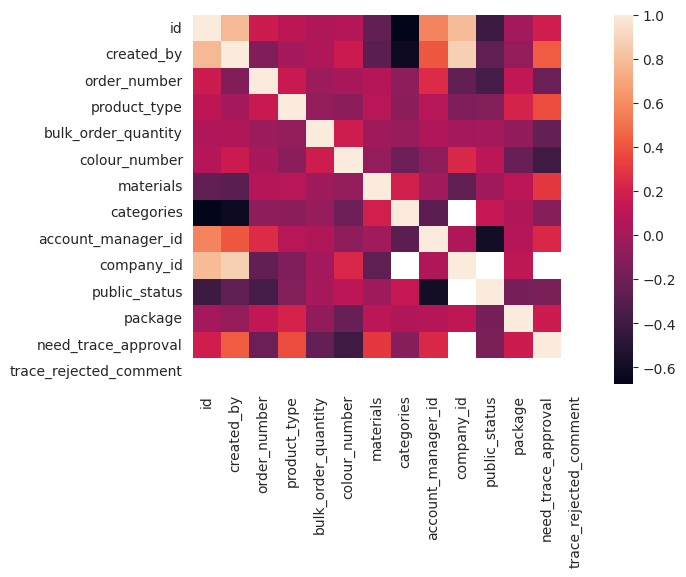

In [ ]:
#checking correlation of variables
sns.heatmap(inquiries.corr())

In [ ]:
# Define the function for setting figure size and x-axis rotation
def set_figure_properties(fig, ax, x_label_rotation=0):
    ax.tick_params(axis='x', labelrotation=x_label_rotation)

    # Set the size of the figure
    fig.set_figheight(6)
    fig.set_figwidth(7)

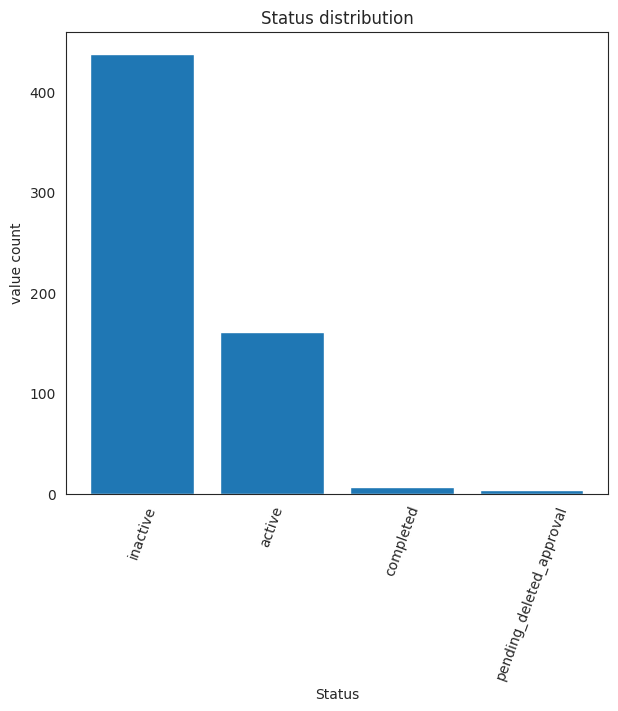

In [ ]:
#categories of inquiry status
status_count = inquiries['status'].value_counts().tolist()

#colors = plt.cm.rainbow(np.linspace(0, 1, len(status_count)))

fig, ax = plt.subplots()

ax.bar(inquiries['status'].unique(),status_count)

# Call the function to set the figure properties
set_figure_properties(fig, ax, x_label_rotation=70)
sns.set_style('darkgrid')

ax.set_title('Status distribution')
ax.set_xlabel('Status')
ax.set_ylabel('value count')
plt.show()
# show the plot
plt.show()

In [ ]:
#replacing numerical variables with categorical
inquiries['package']=inquiries['package'].replace({0:'N/A',1:'High Speed Production',2:'Medium LeadTime Production',
                                                                     3:'Longer LeadTime Production'})

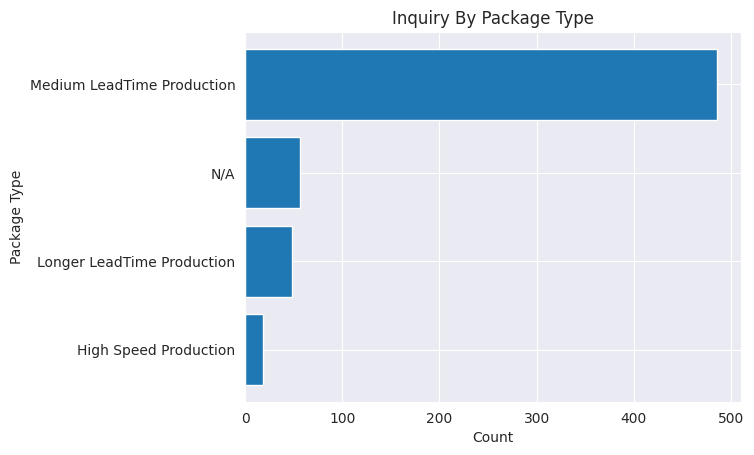

In [ ]:
#visualising the number of inquiries by package type
package_count= inquiries['package'].value_counts().sort_values(ascending=True)

x = package_count.index
y = package_count.values

plt.barh(x, y)
plt.ylabel('Package Type')
plt.xlabel('Count')
plt.title('Inquiry By Package Type')
sns.set_style('white')
plt.show()

In [ ]:
#replacing the numerical values with categotical in the categories column
inquiries['categories']=inquiries['categories'].replace({1:'Womenswear',2:'Menswear',
                                                                     3:'Kidswear',4:'Unisexwear',5:'Accessories',6:'Other'})

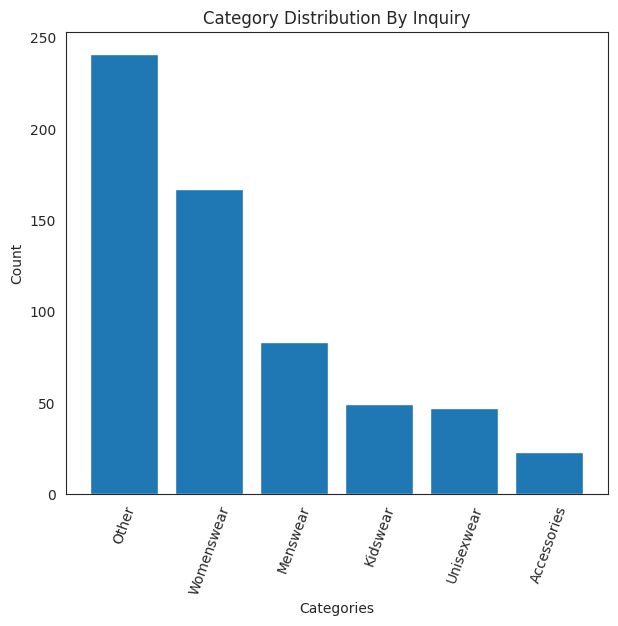

In [ ]:
#visualising the category distribution by inquiry
#categories of status
status_count = inquiries['categories'].value_counts().tolist()

#colors = plt.cm.rainbow(np.linspace(0, 1, len(status_count)))

fig, ax = plt.subplots()

ax.bar(inquiries['categories'].unique(),status_count)

# Call the function to set the figure properties
set_figure_properties(fig, ax, x_label_rotation=70)

ax.set_title('Category Distribution By Inquiry')
ax.set_xlabel('Categories')
ax.set_ylabel('Count')
plt.show()
sns.set_style('white')

# show the plot
plt.show()

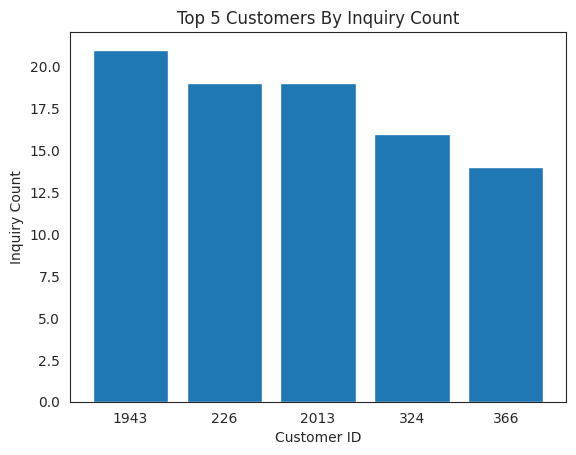

In [ ]:
#visualising the top 5 customers who have patronised the most
most_customers = inquiries['created_by'].value_counts().head(5)


most_customers.index = most_customers.index.astype(str)
# create a bar chart of the grouped data
#fig,ax = plt.subplots()
plt.bar(most_customers.index, most_customers.values)

# Call the function to set the figure properties
set_figure_properties(fig, ax)

plt.title('Top 5 Customers By Inquiry Count')
plt.xlabel('Customer ID')
plt.ylabel('Inquiry Count')
sns.set_style('white')
plt.show()

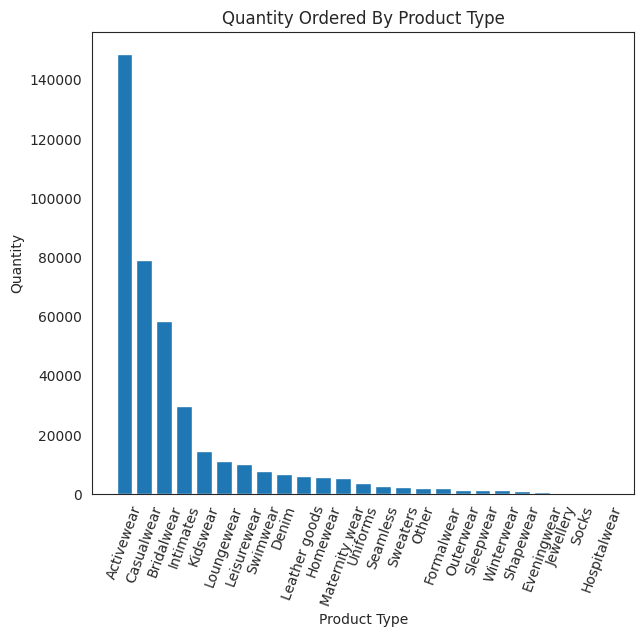

In [ ]:
#visualising the quantity ordered by product type

#joining the inuqiries and product dataframe by the common column 'id'
inquiries= inquiries.merge(product,left_on='product_type',right_on='id')
inquiries

product_df = inquiries.groupby('name').sum()['bulk_order_quantity'].sort_values(ascending=False)

# create a bar chart of the grouped data
fig,ax = plt.subplots()
ax.bar(product_df.index, product_df.values)

# Call the function to set the figure properties
set_figure_properties(fig, ax, x_label_rotation=70)

ax.set_title('Quantity Ordered By Product Type')
ax.set_xlabel('Product Type')
ax.set_ylabel('Quantity')
sns.set_style('white')
plt.show()

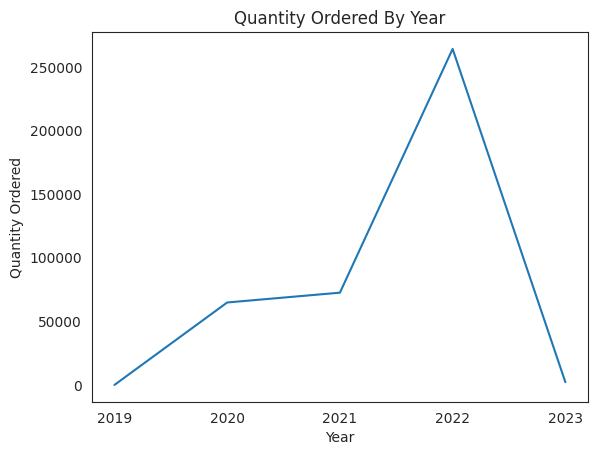

In [ ]:
#visualising the quantity ordered by year

#splitting by '-' to derive the year by its index position
inquiries['year'] = inquiries['created_at_x'].apply(lambda x:x.split('-')[0])

#grouping quantity by year
quantitybyyear = inquiries.groupby('year').sum()['bulk_order_quantity'].sort_values(ascending=False)

#converting the resulting series to dataframe
quantitybyyear = quantitybyyear.to_frame()

#resetting index level
quantitybyyear= quantitybyyear.reset_index(level=0)

#creating custom order to sort the dataframe
custom_order = ['2019', '2020', '2021', '2022', '2023']

# sort the Series by the custom order of values
quantitybyyear = quantitybyyear.sort_values(by=['year'],key=lambda x: x.map({v: i for i, v in enumerate(custom_order)}))


x = quantitybyyear['year']
y = quantitybyyear['bulk_order_quantity']
# Create the plot
plt.plot(x, y)

# Set the x and y axis labels
plt.xlabel("Year")
plt.ylabel("Quantity Ordered")

# Set the plot title
plt.title("Quantity Ordered By Year")

# Show the plot
plt.show()

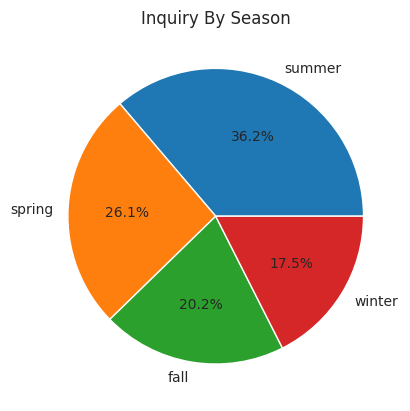

In [ ]:
#visualising the inquiries by season


#defining a function that assigns season
def get_season(dt):
    """
    Returns the season for a given datetime object.
    """
    # Split the year into quarters based on months
    quarters = [(1, 2, 3), (4, 5, 6), (7, 8, 9), (10, 11, 12)]

    # Get the month of the datetime object
    month = dt.month

    # Determine which quarter the month is in
    quarter = next(i for i, q in enumerate(quarters) if month in q)

    # Return the season based on the quarter
    if quarter == 0:
        return 'winter'
    elif quarter == 1:
        return 'spring'
    elif quarter == 2:
        return 'summer'
    else:
        return 'fall'


#converting inquiry creation date to datetime
inquiries['created_at'] = pd.to_datetime(inquiries['created_at_x'])
#extracting the date
inquiries['created_at'] = inquiries['created_at'].dt.date

#applying the function to derive the season for each inquiry
inquiries['season'] = inquiries['created_at'].apply(get_season)

#counting the number of inquiries by season
season_count = inquiries['season'].value_counts()

#plotting on a pie chart
fig, ax = plt.subplots()
ax.pie(season_count.values, labels=season_count.index, autopct='%1.1f%%')

# Set the plot title
ax.set_title("Inquiry By Season")

# Show the plot
plt.show()

#**Data Cleaning and Feature Transformation**

In [ ]:
# Ranking orders by their time of creation and by Customer ID
inquiries['Row Num'] = inquiries.groupby(['created_by'])['created_at'].rank(method='first')

# Sorting values by Customer ID and Order Date in ascending order
inquiries.sort_values(by= ['created_by','created_at'], inplace = True)
inquiries = inquiries.reset_index(drop = True)
inquiries

,id_x,created_by,style_number,order_number,product_type,bulk_order_quantity,colour_number,materials,currency,additional_information,deleted_at,created_at_x,updated_at_x,categories,account_manager_id,company_id,default_image,status,public_status,package,product_name_consumer,product_name_non_consumer,need_trace_approval,trace_rejected_comment,trace_tracking_code,style_name,id_y,name,created_at_y,updated_at_y,short_code,year,created_at,season,Row Num
0,17,117,210528001LAA,1,24,1,1,4,GBP,NaN,NaN,2019-11-03 08:06:29,2022-06-03 16:21:12,Other,402.0,12.0,NaN,inactive,1,Medium LeadTime Production,NaN,NaN,NaN,NaN,NaN,NaN,24,Swimwear,2022-12-22 04:23:01,2022-12-22 04:23:01,swim,2019,2019-11-03,fall,1.0
1,18,117,210528002LAA,2,24,1,2,4,GBP,NaN,NaN,2019-11-03 08:07:04,2022-06-03 16:19:31,Other,402.0,12.0,NaN,inactive,1,Medium LeadTime Production,NaN,NaN,NaN,NaN,NaN,NaN,24,Swimwear,2022-12-22 04:23:01,2022-12-22 04:23:01,swim,2019,2019-11-03,fall,2.0
2,19,117,210528003LAA,3,24,1,2,4,GBP,NaN,NaN,2019-11-03 08:07:27,2022-06-03 16:22:43,Other,402.0,12.0,NaN,inactive,1,Medium LeadTime Production,NaN,NaN,NaN,NaN,NaN,NaN,24,Swimwear,2022-12-22 04:23:01,2022-12-22 04:23:01,swim,2019,2019-11-03,fall,3.0
3,20,117,210528004LAA,4,24,3,3,4,GBP,NaN,NaN,2019-11-03 08:08:05,2022-06-03 16:17:43,Other,402.0,12.0,NaN,inactive,1,Medium LeadTime Production,NaN,NaN,NaN,NaN,NaN,NaN,24,Swimwear,2022-12-22 04:23:01,2022-12-22 04:23:01,swim,2019,2019-11-03,fall,4.0
4,21,117,210528005LAA,5,24,1,1,4,GBP,NaN,NaN,2019-11-03 08:08:25,2022-06-03 16:16:46,Other,402.0,12.0,NaN,inactive,1,Medium LeadTime Production,NaN,NaN,NaN,NaN,NaN,NaN,24,Swimwear,2022-12-22 04:23:01,2022-12-22 04:23:01,swim,2019,2019-11-03,fall,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,837,2028,221115001ESB,1,13,50,2,1,USD,I am wanting to manufacture these in a high quality apple/plant leather or an equivalent recycled material suiting the puffer style designed for these cosmetic bags. The hardware will be gold and high end.,NaN,2022-11-15 07:14:04,2022-11-15 07:43:45,Accessories,2017.0,NaN,NaN,active,1,Medium LeadTime Production,NaN,NaN,NaN,NaN,NaN,NaN,13,Leather goods,2022-12-22 04:23:01,2022-12-22 04:23:01,leather,2022,2022-11-15,fall,1.0
606,838,2031,221122001ODA,1,13,300,4,4,USD,NaN,NaN,2022-11-22 21:51:53,2022-11-26 16:32:44,Accessories,2017.0,NaN,NaN,active,1,High Speed Production,NaN,NaN,NaN,NaN,NaN,NaN,13,Leather goods,2022-12-22 04:23:01,2022-12-22 04:23:01,leather,2022,2022-11-22,fall,1.0
607,841,2042,221219001LEC,1,10,1000,4,3,USD,NaN,NaN,2022-12-19 11:48:56,2023-01-23 05:37:17,Womenswear,402.0,NaN,NaN,active,1,Medium LeadTime Production,NaN,NaN,NaN,NaN,NaN,Bra,10,Intimates,2022-12-22 04:23:01,2022-12-22 04:23:01,intimates,2022,2022-12-19,fall,1.0
608,842,2043,221230001NNA,1,15,50,3,1,GBP,NaN,NaN,2022-12-30 11:49:38,2022-12-30 11:50:55,Womenswear,NaN,NaN,NaN,inactive,0,High Speed Production,NaN,NaN,NaN,NaN,NaN,Pyjamas,15,Loungewear,2022-12-22 04:23:01,2022-12-22 04:23:01,lounge,2022,2022-12-30,fall,1.0


In [ ]:
#Lambda function to filter for customers with more than 2 orders
filter_func = lambda x: len(x) > 2

#Using groupby and filter to create new dataframe with selected customers
inquiries = inquiries.groupby('created_by').filter(filter_func)
inquiries

,id_x,created_by,style_number,order_number,product_type,bulk_order_quantity,colour_number,materials,currency,additional_information,deleted_at,created_at_x,updated_at_x,categories,account_manager_id,company_id,default_image,status,public_status,package,product_name_consumer,product_name_non_consumer,need_trace_approval,trace_rejected_comment,trace_tracking_code,style_name,id_y,name,created_at_y,updated_at_y,short_code,year,created_at,season,Row Num
0,17,117,210528001LAA,1,24,1,1,4,GBP,NaN,NaN,2019-11-03 08:06:29,2022-06-03 16:21:12,Other,402.0,12.0,NaN,inactive,1,Medium LeadTime Production,NaN,NaN,NaN,NaN,NaN,NaN,24,Swimwear,2022-12-22 04:23:01,2022-12-22 04:23:01,swim,2019,2019-11-03,fall,1.0
1,18,117,210528002LAA,2,24,1,2,4,GBP,NaN,NaN,2019-11-03 08:07:04,2022-06-03 16:19:31,Other,402.0,12.0,NaN,inactive,1,Medium LeadTime Production,NaN,NaN,NaN,NaN,NaN,NaN,24,Swimwear,2022-12-22 04:23:01,2022-12-22 04:23:01,swim,2019,2019-11-03,fall,2.0
2,19,117,210528003LAA,3,24,1,2,4,GBP,NaN,NaN,2019-11-03 08:07:27,2022-06-03 16:22:43,Other,402.0,12.0,NaN,inactive,1,Medium LeadTime Production,NaN,NaN,NaN,NaN,NaN,NaN,24,Swimwear,2022-12-22 04:23:01,2022-12-22 04:23:01,swim,2019,2019-11-03,fall,3.0
3,20,117,210528004LAA,4,24,3,3,4,GBP,NaN,NaN,2019-11-03 08:08:05,2022-06-03 16:17:43,Other,402.0,12.0,NaN,inactive,1,Medium LeadTime Production,NaN,NaN,NaN,NaN,NaN,NaN,24,Swimwear,2022-12-22 04:23:01,2022-12-22 04:23:01,swim,2019,2019-11-03,fall,4.0
4,21,117,210528005LAA,5,24,1,1,4,GBP,NaN,NaN,2019-11-03 08:08:25,2022-06-03 16:16:46,Other,402.0,12.0,NaN,inactive,1,Medium LeadTime Production,NaN,NaN,NaN,NaN,NaN,NaN,24,Swimwear,2022-12-22 04:23:01,2022-12-22 04:23:01,swim,2019,2019-11-03,fall,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,828,2013,221102015SOE,15,24,150,1,3,GBP,SC23-0021 Girls Swimming Leggings\nPlease sample in 9 years\nCavico fabric,NaN,2022-11-02 15:01:40,2022-12-20 12:41:42,Kidswear,2017.0,NaN,6362865f11c6f2013.pdf,active,0,Longer LeadTime Production,NaN,NaN,NaN,NaN,NaN,SC23 0021 - GIRLS SWIMMING LEGGINGS,24,Swimwear,2022-12-22 04:23:01,2022-12-22 04:23:01,swim,2022,2022-11-02,fall,15.0
596,829,2013,221102016SOE,16,24,150,1,3,GBP,SC23-0022 Girls Swimming Hijab\nPlease sample in size 9 years\nCavico Fabric,NaN,2022-11-02 15:02:38,2022-12-20 12:42:41,Kidswear,2017.0,NaN,6362869c7271f2013.pdf,active,0,Longer LeadTime Production,NaN,NaN,NaN,NaN,NaN,SC23 0022 - GIRLS SWIMMING HIJAB,24,Swimwear,2022-12-22 04:23:01,2022-12-22 04:23:01,swim,2022,2022-11-02,fall,16.0
597,830,2013,221102017SOE,17,24,150,1,3,GBP,SC23-0012 Ladies Swimming Tunic\nPlease sample in size small (10)\nCavico fabric,NaN,2022-11-02 15:04:14,2022-12-20 12:43:52,Womenswear,2017.0,NaN,636286fc785a72013.pdf,active,0,Longer LeadTime Production,NaN,NaN,NaN,NaN,NaN,SC23 0012 - LADIES SWIMMING TUNIC,24,Swimwear,2022-12-22 04:23:01,2022-12-22 04:23:01,swim,2022,2022-11-02,fall,17.0
598,831,2013,221102018SOE,18,24,150,1,3,GBP,SC23-0013 Ladies Swimming Leggings\nPlease sample in size small (10)\nCavico fabric,NaN,2022-11-02 15:06:12,2022-12-20 12:45:01,Womenswear,2017.0,NaN,636287a7c7a252013.pdf,active,0,Longer LeadTime Production,NaN,NaN,NaN,NaN,NaN,SC23 0013 - LADIES SWIMMING LEGGINGS,24,Swimwear,2022-12-22 04:23:01,2022-12-22 04:23:01,swim,2022,2022-11-02,fall,18.0


In [ ]:
#transposing the dataframe by coverting rows to columns. Each column represents an order quantity while row represents distinct customers
inquiries = inquiries.groupby('created_by')['bulk_order_quantity'].apply(lambda df: df.reset_index(drop=True)).unstack()

#resetting index level
inquiries = inquiries.reset_index(level=0)
inquiries

,created_by,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,117,1.0,1.0,1.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,226,50.0,50.0,40.0,40.0,40.0,40.0,40.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,NaN,NaN
2,250,1.0,1.0,1.0,1.0,1.0,1.0,200.0,100.0,100.0,100.0,200.0,100.0,300.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,270,100.0,50.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,280,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,1933,50.0,50.0,50.0,50.0,50.0,50.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,1934,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,1943,200.0,200.0,200.0,100.0,100.0,100.0,100.0,200.0,200.0,200.0,100.0,100.0,100.0,100.0,100.0,200.0,200.0,200.0,200.0,200.0,200.0
61,1993,55.0,400.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#defining a function that extracts the last non-null order for each customer. The idea is to move the most recent order to the last row which will be the target variable

def get_last_non_null(row):
    for value in row:
        if pd.notna(value):
            last_non_null = value
    return last_non_null

#applying the function
df =inquiries.apply(get_last_non_null, axis=1)

In [ ]:

#defining a function that replaces the last non-null value with zero.

def replace_before_last_non_null(row):
    before_last_non_null_index = None
    for i, value in enumerate(row[:-1]):
        if pd.notna(value):
            before_last_non_null_index = i-1
    if before_last_non_null_index is not None:
        row[before_last_non_null_index] = 0
    return row

#applying the function to the dataframe
inquiries = inquiries.apply(replace_before_last_non_null, axis=1)
inquiries


,created_by,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,117.0,1.0,1.0,1.0,3.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,226.0,50.0,50.0,40.0,40.0,40.0,40.0,40.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,0.0,NaN,NaN
2,250.0,1.0,1.0,1.0,1.0,1.0,1.0,200.0,100.0,100.0,100.0,200.0,100.0,300.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,270.0,100.0,50.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,280.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,1933.0,50.0,50.0,50.0,50.0,50.0,50.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,1934.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,1943.0,200.0,200.0,200.0,100.0,100.0,100.0,100.0,200.0,200.0,200.0,100.0,100.0,100.0,100.0,100.0,200.0,200.0,200.0,200.0,0.0,200.0
61,1993.0,55.0,400.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#concatenating both dataframes. The dataframe containing the last non-null values, 'df' is moved to the last column.
inquiries  = pd.concat([inquiries, df], axis=1)
inquiries = inquiries.drop(columns=[20])

inquiries

,created_by,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,0
0,117.0,1.0,1.0,1.0,3.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,226.0,50.0,50.0,40.0,40.0,40.0,40.0,40.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,0.0,NaN,50.0
2,250.0,1.0,1.0,1.0,1.0,1.0,1.0,200.0,100.0,100.0,100.0,200.0,100.0,300.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,200.0
3,270.0,100.0,50.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0
4,280.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,1933.0,50.0,50.0,50.0,50.0,50.0,50.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0
59,1934.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0
60,1943.0,200.0,200.0,200.0,100.0,100.0,100.0,100.0,200.0,200.0,200.0,100.0,100.0,100.0,100.0,100.0,200.0,200.0,200.0,200.0,0.0,200.0
61,1993.0,55.0,400.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0


In [ ]:
#defining a function that renames all the columns
def rename_columns(df):
    cols = df.columns.tolist()
    for i in range(1, len(cols)):
        cols[i] = 'Order ' + str(i) + ' Quantity'
    df.columns = cols
    return df

#applying the function
inquiries = rename_columns(inquiries)
inquiries

,created_by,Order 1 Quantity,Order 2 Quantity,Order 3 Quantity,Order 4 Quantity,Order 5 Quantity,Order 6 Quantity,Order 7 Quantity,Order 8 Quantity,Order 9 Quantity,Order 10 Quantity,Order 11 Quantity,Order 12 Quantity,Order 13 Quantity,Order 14 Quantity,Order 15 Quantity,Order 16 Quantity,Order 17 Quantity,Order 18 Quantity,Order 19 Quantity,Order 20 Quantity,Order 21 Quantity
0,117.0,1.0,1.0,1.0,3.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,226.0,50.0,50.0,40.0,40.0,40.0,40.0,40.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,0.0,NaN,50.0
2,250.0,1.0,1.0,1.0,1.0,1.0,1.0,200.0,100.0,100.0,100.0,200.0,100.0,300.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,200.0
3,270.0,100.0,50.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0
4,280.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,1933.0,50.0,50.0,50.0,50.0,50.0,50.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0
59,1934.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0
60,1943.0,200.0,200.0,200.0,100.0,100.0,100.0,100.0,200.0,200.0,200.0,100.0,100.0,100.0,100.0,100.0,200.0,200.0,200.0,200.0,0.0,200.0
61,1993.0,55.0,400.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0


In [ ]:
#replacing empty spaces with zeros
inquiries = inquiries.replace(np.nan, 0)
inquiries

,created_by,Order 1 Quantity,Order 2 Quantity,Order 3 Quantity,Order 4 Quantity,Order 5 Quantity,Order 6 Quantity,Order 7 Quantity,Order 8 Quantity,Order 9 Quantity,Order 10 Quantity,Order 11 Quantity,Order 12 Quantity,Order 13 Quantity,Order 14 Quantity,Order 15 Quantity,Order 16 Quantity,Order 17 Quantity,Order 18 Quantity,Order 19 Quantity,Order 20 Quantity,Order 21 Quantity
0,117.0,1.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,226.0,50.0,50.0,40.0,40.0,40.0,40.0,40.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,0.0,0.0,50.0
2,250.0,1.0,1.0,1.0,1.0,1.0,1.0,200.0,100.0,100.0,100.0,200.0,100.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200.0
3,270.0,100.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0
4,280.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,1933.0,50.0,50.0,50.0,50.0,50.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0
59,1934.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0
60,1943.0,200.0,200.0,200.0,100.0,100.0,100.0,100.0,200.0,200.0,200.0,100.0,100.0,100.0,100.0,100.0,200.0,200.0,200.0,200.0,0.0,200.0
61,1993.0,55.0,400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500.0


In [ ]:
#dropping the 'created by' column
inquiries = inquiries.drop(['created_by'], axis=1)

#**Data Splitting**

In [ ]:
#splitting the data into features (x) and target variable (y)
X = inquiries.iloc[:, :-1].values
y = inquiries.iloc[:, -1].values

#**Modelling**

Neural Network

Epoch 1/30
2/2 [==============================] - 3s 694ms/step - loss: 1015142.7500 - val_loss: 86360.9297
Epoch 2/30
2/2 [==============================] - 0s 212ms/step - loss: 666194.0625 - val_loss: 86120.7656
Epoch 3/30
2/2 [==============================] - 0s 66ms/step - loss: 32116984.0000 - val_loss: 86172.8359
Epoch 4/30
2/2 [==============================] - 0s 50ms/step - loss: 32702164.0000 - val_loss: 86261.5625
Epoch 5/30
2/2 [==============================] - 0s 67ms/step - loss: 31904716.0000 - val_loss: 86367.0391
Epoch 6/30
2/2 [==============================] - 0s 56ms/step - loss: 32005318.0000 - val_loss: 86493.3594
Epoch 7/30
2/2 [==============================] - 0s 51ms/step - loss: 944744.3750 - val_loss: 86578.9062
Epoch 8/30
2/2 [==============================] - 0s 47ms/step - loss: 31344424.0000 - val_loss: 86689.0312
Epoch 9/30
2/2 [==============================] - 0s 68ms/step - loss: 969514.6250 - val_loss: 86738.6328
Epoch 10/30
2/2 [================

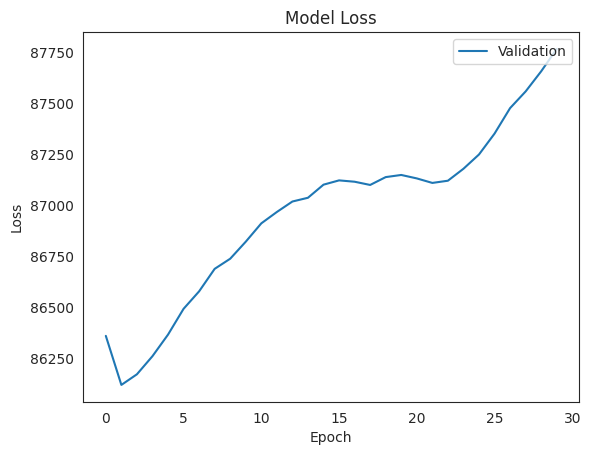

In [ ]:
#setting random seed for reproducibility
tf.random.set_seed(21)



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state =21)


# Building the sequential model
model = Sequential([
    Masking(mask_value=0.0, input_shape=(20,)),
    Dense(1, activation ='linear', kernel_regularizer=regularizers.l2(0.01)),
  Dropout(0.5)
])
model.compile(loss="mean_squared_error", optimizer="adam")

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


# Plot the training and validation loss

plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper right')
plt.show()



In [ ]:
#Evaluating the performance of the neural network

#make predictions
y_pred = model.predict(X_test)

# Evaluate the model on the testing data
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse, mae)

1/1 [==============================] - 0s 171ms/step
296.25283354031507 189.94028257068834


#**Comparing the Neural Network with Decision Tree, Linear Regression and Random Forest by RMSE**

1/1 [==============================] - 0s 63ms/step


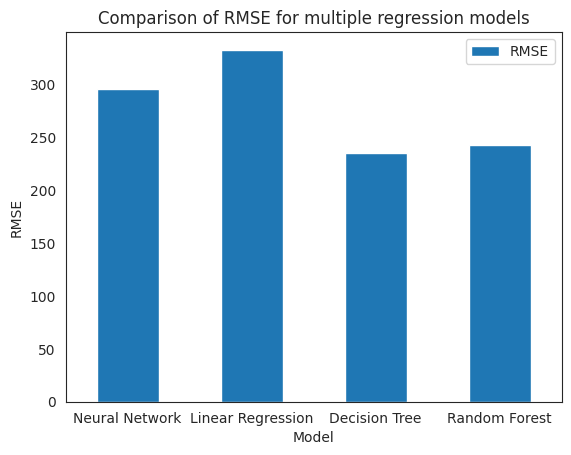

[('Neural Network', 296.25283354031507), ('Linear Regression', 333.17030203777523), ('Decision Tree', 235.78257156251303), ('Random Forest', 242.83078690401067)]


In [ ]:
# Build multiple regression models
models = [('Neural Network', model),('Linear Regression', LinearRegression().fit(X_train, y_train)),
          ('Decision Tree', DecisionTreeRegressor().fit(X_train, y_train)),
          ('Random Forest', RandomForestRegressor().fit(X_train, y_train))]

# Evaluating the performance of each model based on their RMSE
rmse_values = []
for model_name, model in models:
    ypred = model.predict(X_test)
    rmse = mean_squared_error(y_test, ypred, squared=False)
    rmse_values.append((model_name, rmse))

# Create a box plot
df = pd.DataFrame(rmse_values, columns=['Model', 'RMSE'])
ax = df.plot.bar(x='Model', y='RMSE', rot=0)
ax.set_ylabel('RMSE')
ax.set_title('Comparison of RMSE for multiple regression models')
plt.show()
print(rmse_values)

#**Comparing the Neural Network with Decision Tree, Linear Regression and Random Forest by MAE**  

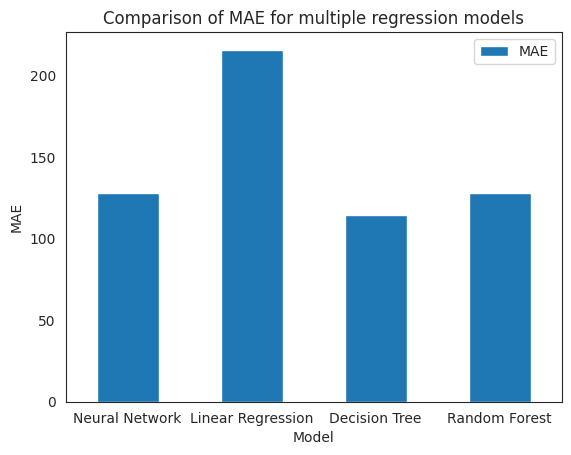

[('Neural Network', 128.15947368421052), ('Linear Regression', 215.8776044104203), ('Decision Tree', 114.42105263157895), ('Random Forest', 127.84631578947368)]


In [ ]:
models = [('Neural Network', model),('Linear Regression', LinearRegression().fit(X_train, y_train)),
          ('Decision Tree', DecisionTreeRegressor().fit(X_train, y_train)),
          ('Random Forest', RandomForestRegressor().fit(X_train, y_train))]

# Evaluating the performance of each model based on their MAE
mae_values = []
for model_name, model in models:
    ypred = model.predict(X_test)
    mae = mean_absolute_error(y_test, ypred)
    mae_values.append((model_name, mae))

# Create a box plot
df = pd.DataFrame(mae_values, columns=['Model', 'MAE'])
ax = df.plot.bar(x='Model', y='MAE', rot=0)
ax.set_ylabel('MAE')
ax.set_title('Comparison of MAE for multiple regression models')
plt.show()
print(mae_values)

#**Visualising the predicted and actual values for all models**

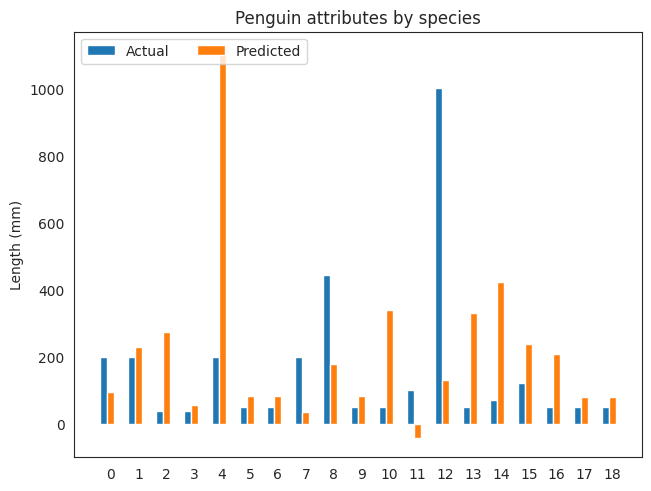

In [ ]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)


({'Actual': y_test, 'Predicted': y_pred})

species = (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18)
penguin_means = {
    'Actual':y_test,
    'Predicted': y_pred,
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
#ax.set_ylim(0, 250)

plt.show()

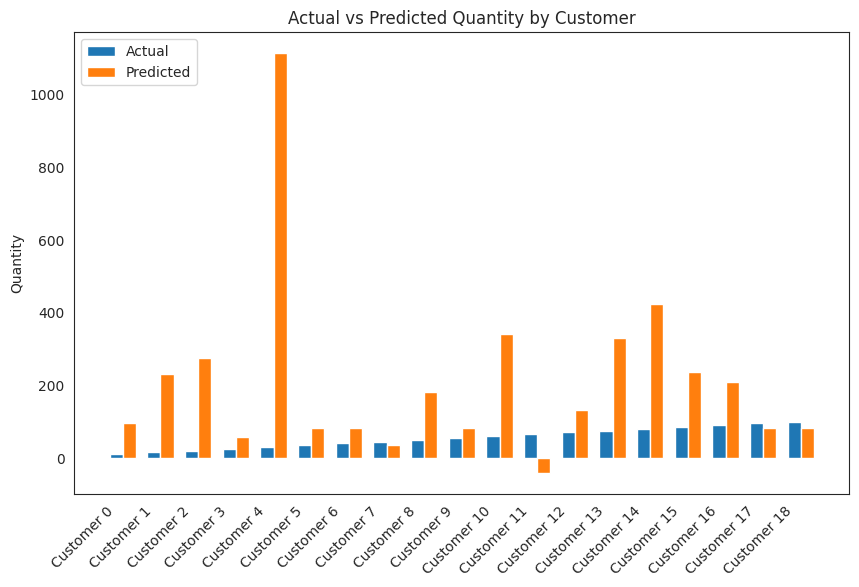

In [ ]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

customers = [f"Customer {i}" for i in range(len(y_test))] # Customer 0 to 18

penguin_means = {
    'Actual': y_test,
    'Predicted': y_pred,
}

x = np.arange(len(customers))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(10, 6))

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3, labels=[f"{val:.2f}" for val in measurement]) # Modified to remove labels
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Quantity')
ax.set_title('Actual vs Predicted Quantity by Customer')
ax.set_xticks(x)
ax.set_xticklabels(customers, rotation=45, ha="right")
ax.legend(loc='upper left')


plt.show()


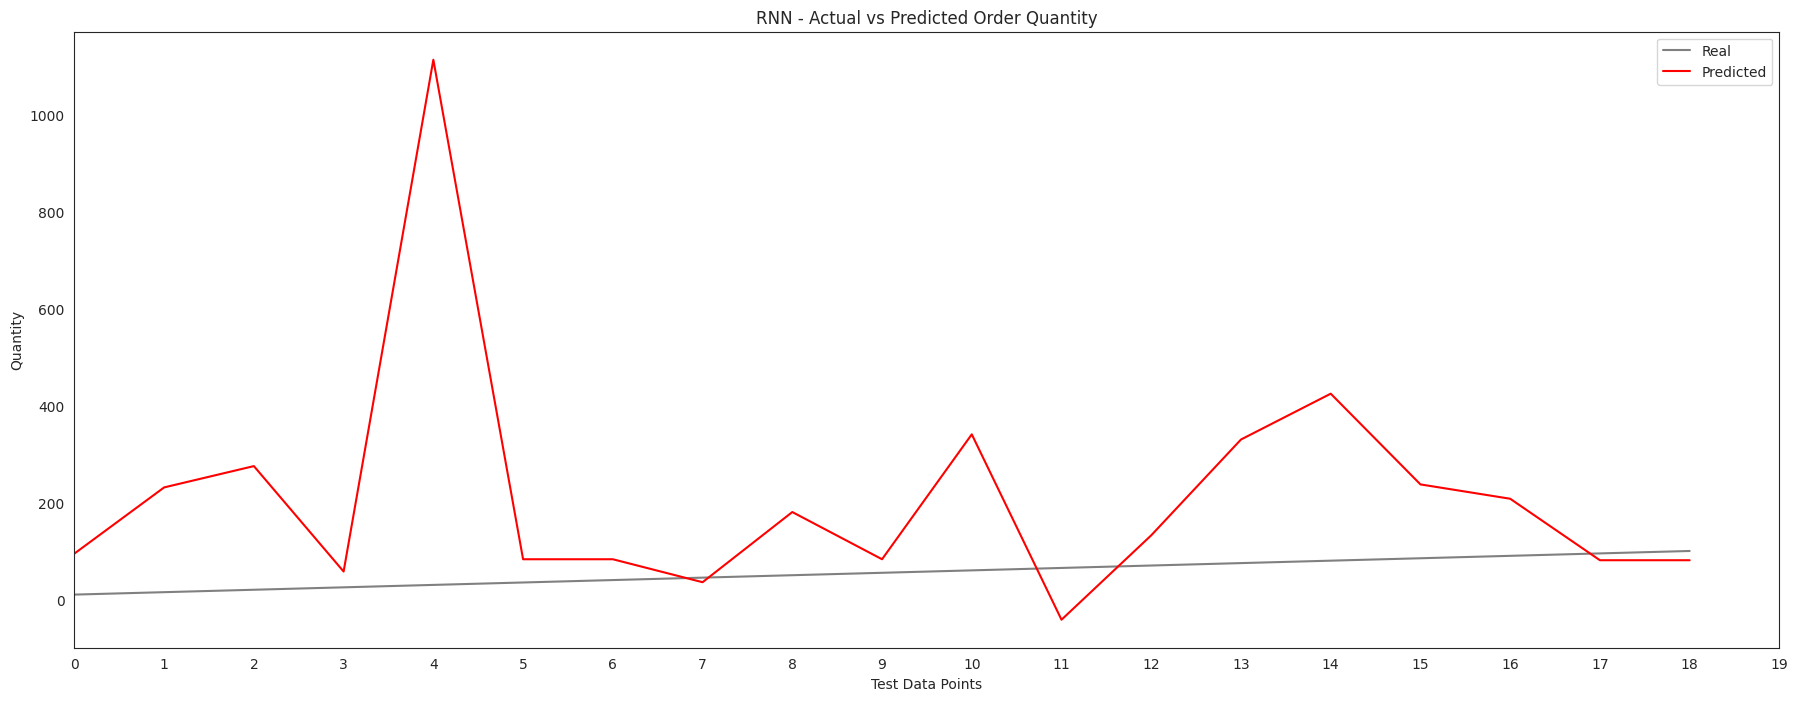

In [ ]:
#visualising the neural netowrk predicted vs actual values for data points in the test set

def plot_predictions(y_test, y_pred):
    plt.figure(figsize=(22, 8))  # set the figure size
    plt.plot(y_test, color="gray", label="Real")
    plt.plot(y_pred, color="red", label="Predicted")
    plt.title("RNN - Actual vs Predicted Order Quantity")
    plt.xlabel("Test Data Points")
    plt.ylabel("Quantity")
    plt.xlim(0, 19)
    plt.xticks(range(0, 20, 1), range(0, 20, 1))
    plt.legend()
    plt.show()

plot_predictions(y_test, y_pred)

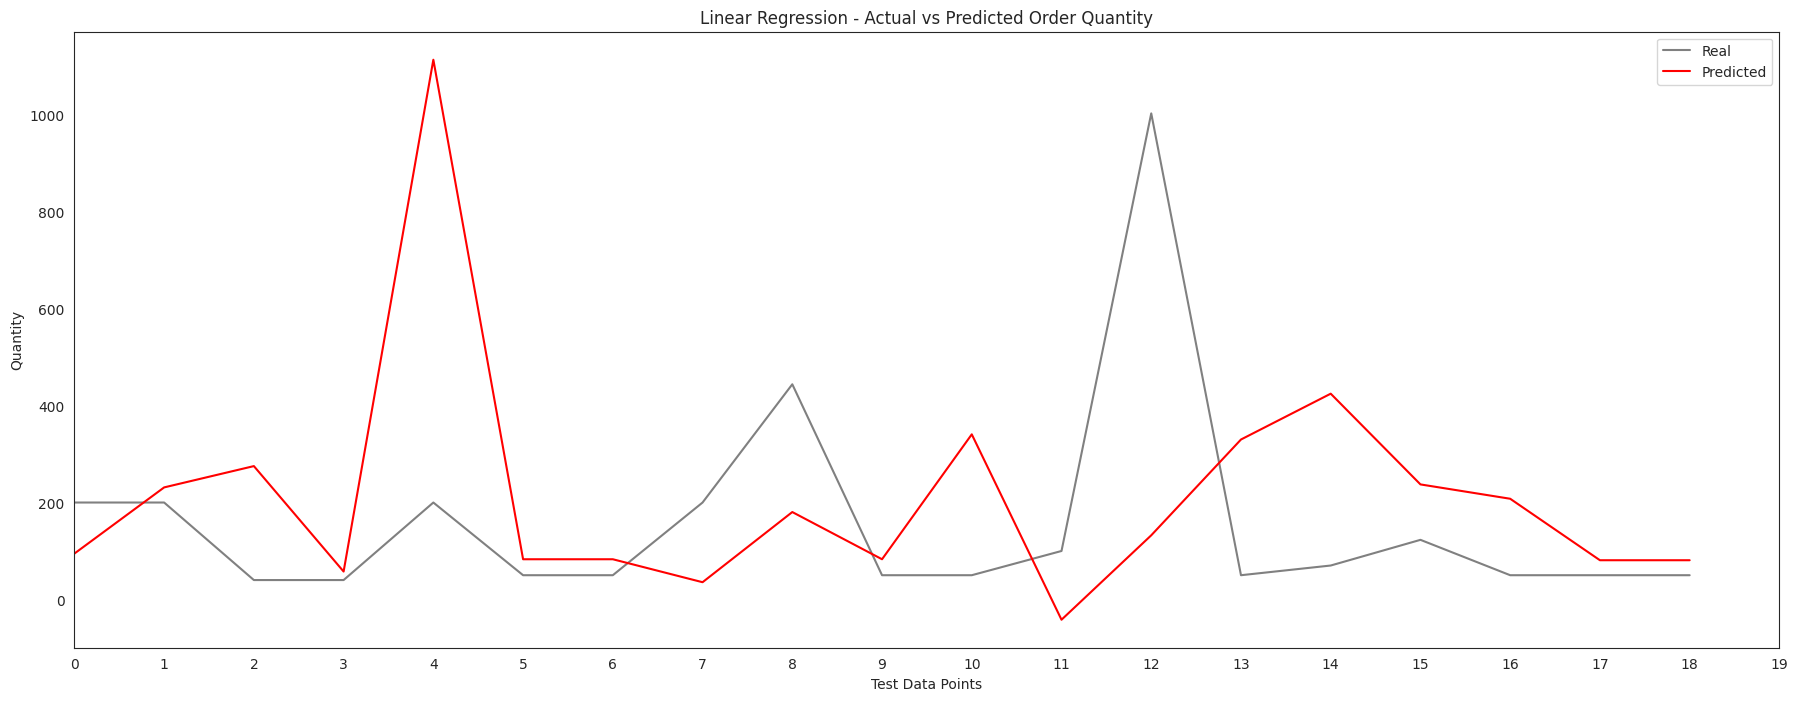

In [ ]:
#visualising the linear regression predicted vs actual values for data points in the test set


linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

def plot_predictions(y_test, y_pred):
    plt.figure(figsize=(22, 8))  # set the figure size
    plt.plot(y_test, color="gray", label="Real")
    plt.plot(y_pred, color="red", label="Predicted")
    plt.title("Linear Regression - Actual vs Predicted Order Quantity")
    plt.xlabel("Test Data Points")
    plt.ylabel("Quantity")
    plt.xlim(0, 19)
    plt.xticks(range(0, 20, 1), range(0, 20, 1))
    plt.legend()
    plt.show()

plot_predictions(y_test, y_pred)

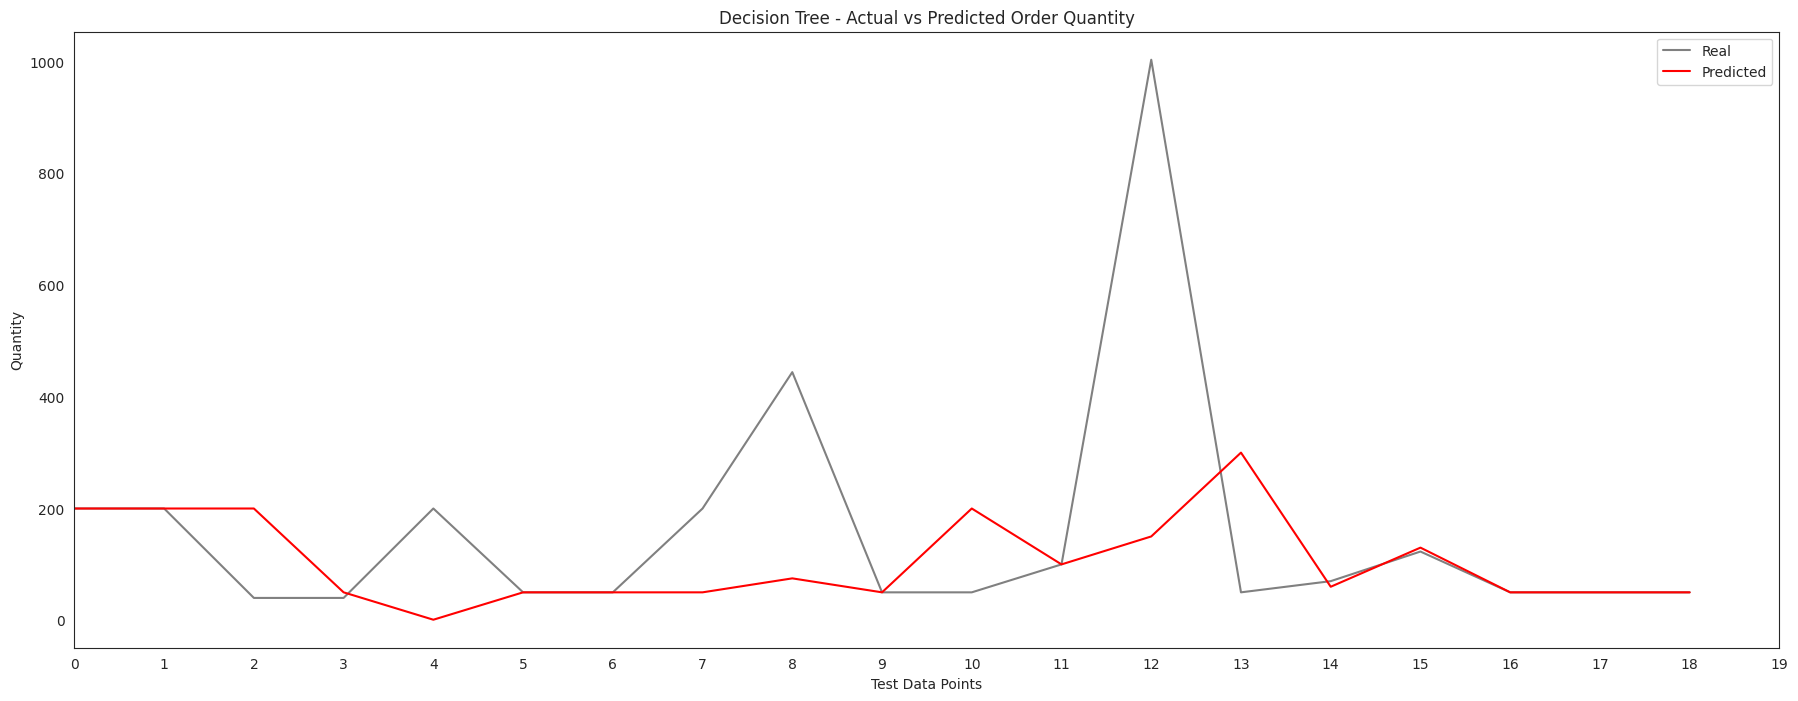

In [ ]:
#visualising the decision tree predicted vs actual values for data points in the test set

dtree = DecisionTreeRegressor()
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)

def plot_predictions(y_test, y_pred):
    plt.figure(figsize=(22, 8))  # set the figure size
    plt.plot(y_test, color="gray", label="Real")
    plt.plot(y_pred, color="red", label="Predicted")
    plt.title("Decision Tree - Actual vs Predicted Order Quantity")
    plt.xlabel("Test Data Points")
    plt.ylabel("Quantity")
    plt.xlim(0, 19)
    plt.xticks(range(0, 20, 1), range(0, 20, 1))
    plt.legend()
    plt.show()

plot_predictions(y_test, y_pred)

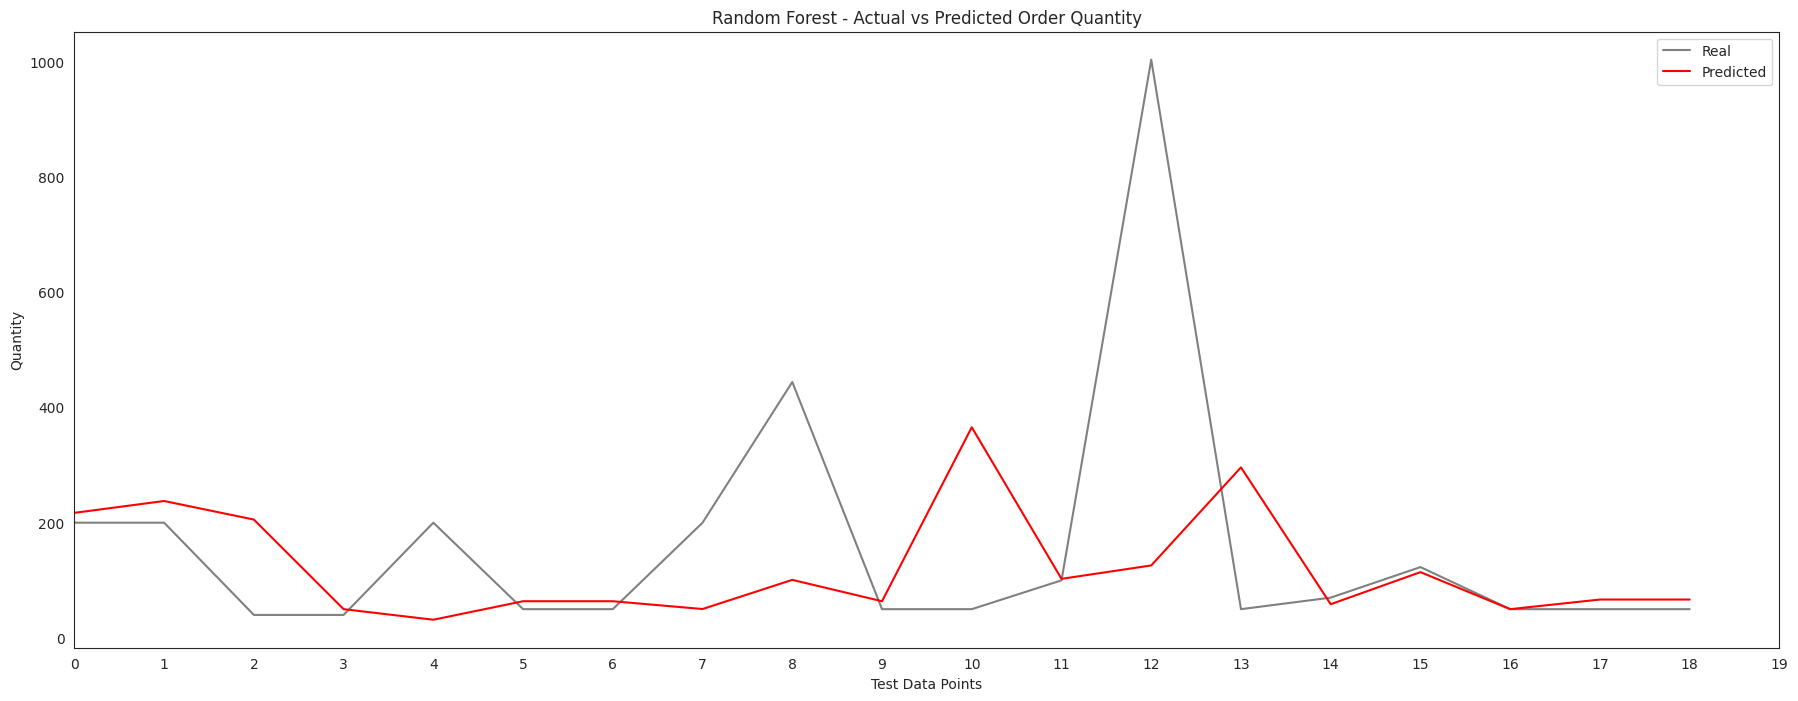

In [ ]:
#visualising the random forest predicted vs actual values for data points in the test set


rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

def plot_predictions(y_test, y_pred):
    plt.figure(figsize=(22, 8))  # set the figure size
    plt.plot(y_test, color="gray", label="Real")
    plt.plot(y_pred, color="red", label="Predicted")
    plt.title("Random Forest - Actual vs Predicted Order Quantity")
    plt.xlabel("Test Data Points")
    plt.ylabel("Quantity")
    plt.xlim(0, 19)
    plt.xticks(range(0, 20, 1), range(0, 20, 1))
    plt.legend()
    plt.show()

plot_predictions(y_test, y_pred)

#Performing Out-Of-Sample Testing To Evaluate Model's Generalization

In [ ]:
#New data points were created for two customers, Customer A and customer B to evaluate how each model performs on unseen data.

In [ ]:
#defining a function that reshapes input arrays such that they would equal the length required by the model

def reshape_arrays(arrays):
    new_arrays = []
    for array in arrays:
        if len(array) >= 20:
            new_arrays.append(array[:20])
        else:
            padding = np.zeros(20 - len(array))
            new_array = np.concatenate((array, padding))
            new_arrays.append(new_array)
    return new_arrays


In [ ]:
# Create a new data point as a numpy array for customer A
customer_A = np.array([[1120,1325,1232,1462,1770]])

#applying the function to reshape the array
customer_A = reshape_arrays(customer_A)

for model_name, model in models:
    prediction = model.predict(customer_A)
    print(f"{model_name} prediction: {prediction}")

Neural Network prediction: [1111.75]
Linear Regression prediction: [128.91268924]
Decision Tree prediction: [500.]
Random Forest prediction: [1083.2]


In [ ]:
# Create a new data point as a numpy array for customer B
customer_B = np.array([[92.0,	196.0,	134.0,	167.0,	105.0,	107.0]])

#applying the function to reshape the array
customer_B = reshape_arrays(customer_B)

# Call the predict() method on the model object and pass in the new data point
prediction = model.predict(customer_B)

for model_name, model in models:
    prediction = model.predict(customer_B)
    print(f"{model_name} prediction: {prediction}")

Neural Network prediction: [253.85]
Linear Regression prediction: [344.83185474]
Decision Tree prediction: [200.]
Random Forest prediction: [262.55]


#Hyperparameter Tuning

In [ ]:
#decision tree performed best of all models considered. It was therefore selected for optimization before deployment.

params={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

dtree = DecisionTreeRegressor()
kf = KFold(n_splits=5, shuffle = True, random_state =21)
dtree_cv = GridSearchCV(dtree, param_grid=params, cv=kf, scoring = 'neg_mean_squared_error')

dtree_cv.fit(X_train, y_train)
print(dtree_cv.best_params_, dtree_cv.best_score_)



{'max_depth': 7, 'max_features': None, 'max_leaf_nodes': 40, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.1, 'splitter': 'random'} -509005.5801704043


#Preparation for Deployment

In [ ]:
#the default hyperparameters yielded better result than optimization. The decision tree is loaded into a pickle file and exported for deployment and integration into the company's platform


# saving the trained decision tree model into a pickle file
with open('dtree.pkl', 'wb') as f:
    pickle.dump(dtree, f)


In [ ]:
#the pickle file is exported using the command


# Define the source and destination file paths
src_path = 'dtree.pkl'
dest_path = '/path/to/destination/directory/dtree.pkl'

# Copy the file to the destination directory. The command is commented. Replace dest_path with an actual file directory and uncomment the next line to export successfully.
#shutil.copy(src_path, dest_path)
